### Import important libraries

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import time

### Check the null values

In [5]:
#  Load the dataset
file_path = 'heart_disease_health_indicators.csv'
data = pd.read_csv(file_path)
data.isnull().sum()

HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

### Splitting the data

In [6]:
# Split the data 
X = data.drop(columns=['HeartDiseaseorAttack'])
y = data['HeartDiseaseorAttack']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Building and evaluating the model

Epoch 1/20
6342/6342 [==============================] - 20s 3ms/step - loss: 0.2421 - accuracy: 0.9067 - val_loss: 0.2349 - val_accuracy: 0.9093
Epoch 2/20
6342/6342 [==============================] - 18s 3ms/step - loss: 0.2379 - accuracy: 0.9077 - val_loss: 0.2339 - val_accuracy: 0.9092
Epoch 3/20
6342/6342 [==============================] - 18s 3ms/step - loss: 0.2371 - accuracy: 0.9079 - val_loss: 0.2341 - val_accuracy: 0.9088
Epoch 4/20
1586/1586 [==============================] - 3s 2ms/step - loss: 0.2349 - accuracy: 0.9093
Test Accuracy: 90.93%
1586/1586 [==============================] - 2s 1ms/step
Confusion Matrix:
 [[45810   230]
 [ 4373   320]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     46040
           1       0.58      0.07      0.12      4693

    accuracy                           0.91     50733
   macro avg       0.75      0.53      0.54     50733
weighted avg       0.88      0.91     

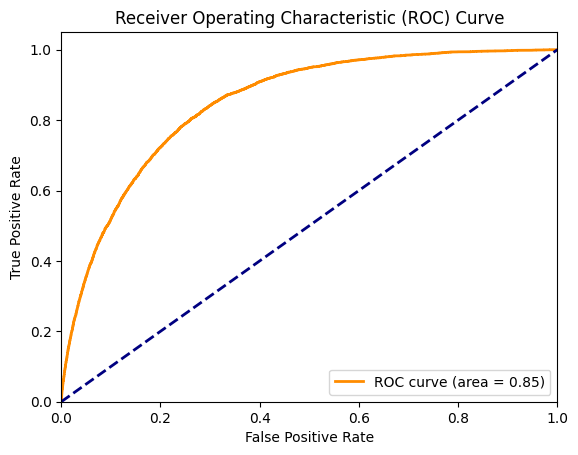

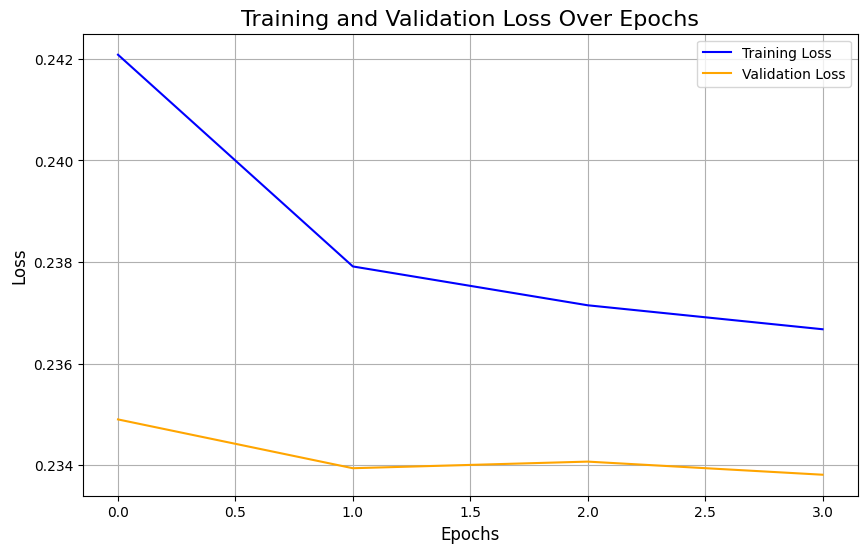

Reloading Tuner from .\untitled_project\tuner0.json
Best Hyperparameters:
Units layer 1: 64
Units layer 2: 64
Learning rate: 0.001
Epoch 1/10
6342/6342 [==============================] - 17s 3ms/step - loss: 0.2418 - accuracy: 0.9068 - val_loss: 0.2349 - val_accuracy: 0.9089
Epoch 2/10
6342/6342 [==============================] - 16s 3ms/step - loss: 0.2382 - accuracy: 0.9076 - val_loss: 0.2347 - val_accuracy: 0.9089
Epoch 3/10
6342/6342 [==============================] - 17s 3ms/step - loss: 0.2372 - accuracy: 0.9079 - val_loss: 0.2347 - val_accuracy: 0.9093
Epoch 4/10
6342/6342 [==============================] - 16s 3ms/step - loss: 0.2367 - accuracy: 0.9081 - val_loss: 0.2339 - val_accuracy: 0.9092
Epoch 5/10
6342/6342 [==============================] - 16s 3ms/step - loss: 0.2363 - accuracy: 0.9082 - val_loss: 0.2338 - val_accuracy: 0.9092
Epoch 6/10
6342/6342 [==============================] - 16s 3ms/step - loss: 0.2358 - accuracy: 0.9083 - val_loss: 0.2350 - val_accuracy: 0.9088

Reusing TensorBoard on port 6006 (pid 18084), started 19:42:22 ago. (Use '!kill 18084' to kill it.)

In [7]:
def build_model():
    # Defines the structure of the neural network model
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(21,)),  # First layer with 64 units, ReLU activation
        layers.Dense(32, activation='relu'),  # Second layer with 32 units, ReLU activation
        layers.Dense(16, activation='relu'),  # Third layer with 16 units, ReLU activation
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification, sigmoid activation
    ])
    return model

# Instantiate and compile the model
model = build_model()  # Builds the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate of 0.001
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'])  # Metric to track is accuracy

# 3. Set up TensorBoard and EarlyStopping
log_dir = f"logs/fit/{time.strftime('%Y%m%d-%H%M%S')}"  # Logs directory for TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)  # Callback for TensorBoard logging

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)  # Early stopping on val accuracy

# 4. Train the model with TensorBoard and EarlyStopping
history = model.fit(X_train, y_train,  # Train on X_train, y_train
                    validation_data=(X_test, y_test),  # Validation on X_test, y_test
                    epochs=20, batch_size=32,  # Train for 20 epochs with batch size 32
                    callbacks=[early_stopping, tensorboard_callback])  # Use early stopping and TensorBoard

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)  # Evaluate the model on the test set
print(f'Test Accuracy: {accuracy * 100:.2f}%')  # Print the test accuracy

# Confusion Matrix
y_pred_proba = model.predict(X_test)  # Get predicted probabilities on the test set
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

cm = confusion_matrix(y_test, y_pred)  # Calculate confusion matrix
print("Confusion Matrix:\n", cm)  # Print confusion matrix

# Classification report (Precision, Recall, F1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))  # Print classification report

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Calculate ROC-AUC score
print(f'ROC-AUC Score: {roc_auc:.2f}')  # Print ROC-AUC score

# 6. Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # Calculate false positive and true positive rates
roc_auc = auc(fpr, tpr)  # Calculate area under ROC curve

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot diagonal line for random guessing
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # X-axis label
plt.ylabel('True Positive Rate')  # Y-axis label
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title of the plot
plt.legend(loc="lower right")  # Place the legend
plt.show()  # Show the plot

# 7. Plot training and validation loss in one graph
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(history.history['loss'], label='Training Loss', color='blue')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Plot validation loss
plt.title('Training and Validation Loss Over Epochs', fontsize=16)  # Title of the plot
plt.xlabel('Epochs', fontsize=12)  # X-axis label
plt.ylabel('Loss', fontsize=12)  # Y-axis label
plt.legend(loc='upper right')  # Place the legend
plt.grid(True)  # Show grid
plt.show()  # Show the plot

# Hyperparameter Tuning with Keras Tuner
def build_tuned_model(hp):
    # Define model with tunable hyperparameters
    model = models.Sequential()
    model.add(layers.Dense(hp.Int('units_1', min_value=64, max_value=128, step=32), activation='relu', input_shape=(21,)))  # First layer, tunable units
    model.add(layers.Dense(hp.Int('units_2', min_value=32, max_value=64, step=16), activation='relu'))  # Second layer, tunable units
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile with tunable learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4])), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])  # Binary crossentropy for binary classification
    return model

# Instantiate the tuner with reduced hyperband iterations
tuner = kt.Hyperband(build_tuned_model,  # Hyperband tuner
                     objective='val_accuracy',  # Maximize validation accuracy
                     max_epochs=10,  # Maximum epochs
                     factor=2,  
                     hyperband_iterations=2,  # Reduce number of Hyperband iterations
                     ) 

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))  # Start hyperparameter search

# Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Get best hyperparameters
# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Units layer 1: {best_hps.get('units_1')}")  # Print best number of units in layer 1
print(f"Units layer 2: {best_hps.get('units_2')}")  # Print best number of units in layer 2
print(f"Learning rate: {best_hps.get('learning_rate')}")  # Print best learning rate
best_model = tuner.hypermodel.build(best_hps)  # Build model with best hyperparameters
best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)  # Train the best model

# Final evaluation of the best model
loss, accuracy = best_model.evaluate(X_test, y_test)  # Evaluate best model
print(f'Best Model Test Accuracy: {accuracy * 100:.2f}%')  # Print accuracy of the best model

# TensorBoard: is a powerful tool for visualizing various aspects of a neural network during training. It helps track the training process by displaying metrics like loss, accuracy, weights, gradients, histograms, and more.
%load_ext tensorboard
%tensorboard --logdir logs/fit

### ROC curve
-The AUC represents the area under each ROC curve. An AUC value closer to 1.00 indicates excellent model performance. Here, all the classes have AUCs close to 1, suggesting that the model is highly effective at distinguishing between the classes.

-The dashed diagonal line represents a random classifier 

-The dashed diagonal line represents a random classifier. The closer a ROC curve is to the upper left corner (higher TPR, lower FPR), the better the model is at classifying correctly. If the ROC curve were close to this diagonal line, the model would be no better than random guessing.

- True Positive Rate:


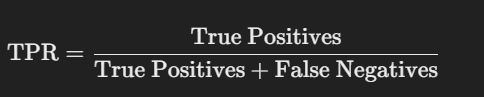

- false positive rate:

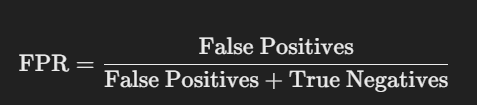

## Precision:
Precision measures how many of the instances predicted as positive are actually positive.

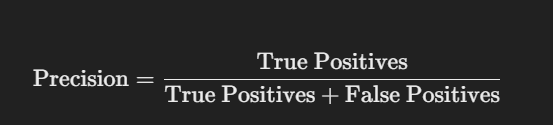

##  Recall 
Recall measures how many of the actual positives were correctly classified by the model.
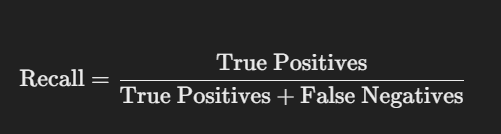

##F1-Score:
The F1-score gives a single score that represents the model’s accuracy in terms of both precision and recall.

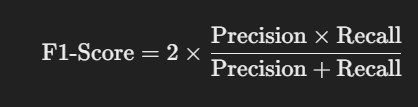
## Support

Support represents the number of actual occurrences of each class in the dataset.
